# Load Packages

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
! pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from keras.layers import Conv2D,ConvLSTM2D,Conv3D,Cropping2D
from keras.layers import Input, Dropout, TimeDistributed, RepeatVector,Activation
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization,Flatten, Dense, Reshape, LSTM
from keras import losses, Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import RMSprop, Adam
import keras

from numpy import reshape
import numpy as np
import matplotlib.pyplot as plt

import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity
import time

# Prepare the datasets of 48 videos

In [4]:
import cv2
import numpy as np

dataset_3D = []
dataset = []

for i in range(48):
    # Open the video file
    video = cv2.VideoCapture("/content/drive/MyDrive/UROP Sibo/A Machine learning problem/VIDEOS/fire_Chimney_video_{}.mp4".format(i))
    
    # Read the frames of the video one by one
    while True:
        # Read the next frame
        ret, frame = video.read()
        
        # If there are no more frames, break out of the loop
        if not ret:
            break
        
        # Convert the frame to grayscale and threshold it to create a binary image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        
        binary_flat = binary.flatten()
        
        dataset.append(binary_flat)
        dataset_3D.append(gray)

dataset = np.array(dataset)
dataset_3D = np.array(dataset_3D)

np.save("dataset.npy", dataset)
np.save("dataset_3D.npy", dataset_3D)

In [5]:
train_dataset = dataset[:640,:]
test_dataset = dataset[-128:,:]
train_dataset3D = dataset_3D[:640,:]
test_dataset3D = dataset_3D[-128:,:]

print(dataset.shape)
print(train_dataset.shape)
print(dataset_3D.shape)

np.save("train_dataset.npy", train_dataset)
np.save("test_dataset.npy", test_dataset)
np.save("train_dataset3D.npy", train_dataset3D)
np.save("test_dataset3D.npy", test_dataset3D)

(768, 16384)
(640, 16384)
(768, 128, 128)


# 1. PCA


In [6]:
X_data = np.load("dataset.npy")
pca = PCA(n_components=2)
pca.fit(X_data)
X_pca=pca.transform(X_data)

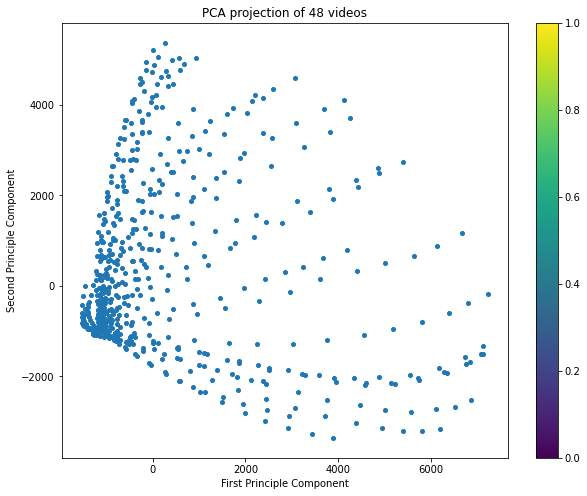

In [7]:
number_of_videos =  48
index_range = number_of_videos*16
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(X_pca[:index_range,0],
                     X_pca[:index_range,1], 
                     s = 16,
                     cmap = plt.get_cmap('jet', number_of_videos))

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} videos".format(number_of_videos))

fig.colorbar(scatter)

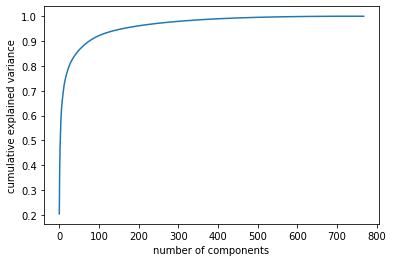

In [8]:
pca = PCA()
pca.fit(X_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 80 components account for just over 90% of the variance. That would lead us to believe that using these 80 components, we would recover most of the essential characteristics of the data. 

## Show 16 snapshots of first video under 32-PCA and original


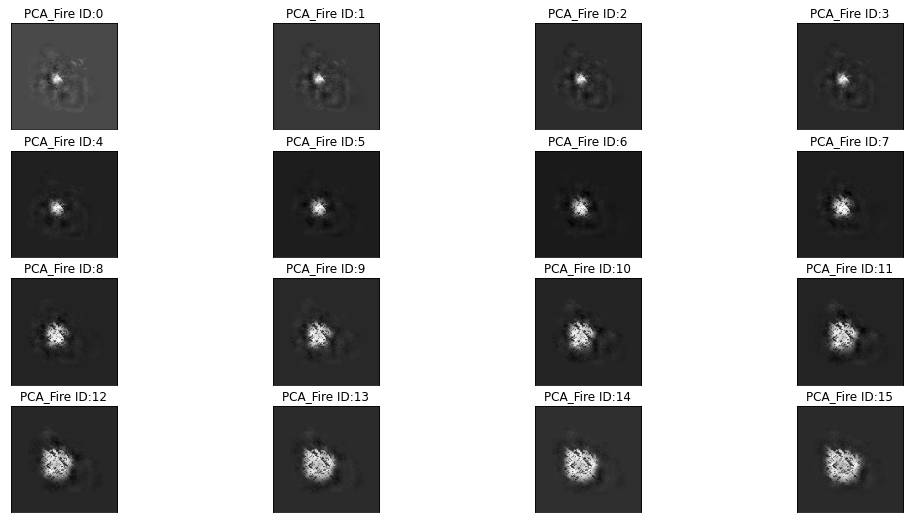

In [9]:
pca = PCA(n_components = 32, whiten = True)
pca_X = pca.fit_transform(X_data)
X_proj_img = pca.inverse_transform(pca_X).reshape(-1,128,128)
fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(X_proj_img[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [10]:
x = np.zeros((16384,))
for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
pca_err_32 = x.sum()/768/128/128


## Show 16 snapshots of first video under 32-PCA


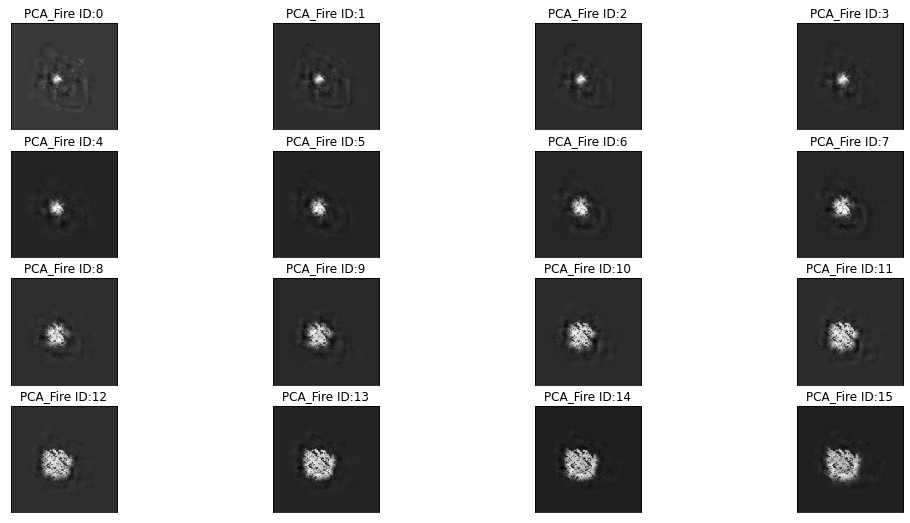

In [11]:
pca = PCA(n_components = 50, whiten = True)
pca_X = pca.fit_transform(X_data)
X_proj_img = pca.inverse_transform(pca_X).reshape(-1,128,128)
fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(X_proj_img[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [12]:
x = np.zeros((16384,))
for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
pca_err_50 =x.sum()/768/128/128

## Show 16 snapshots of first video under 64-PCA


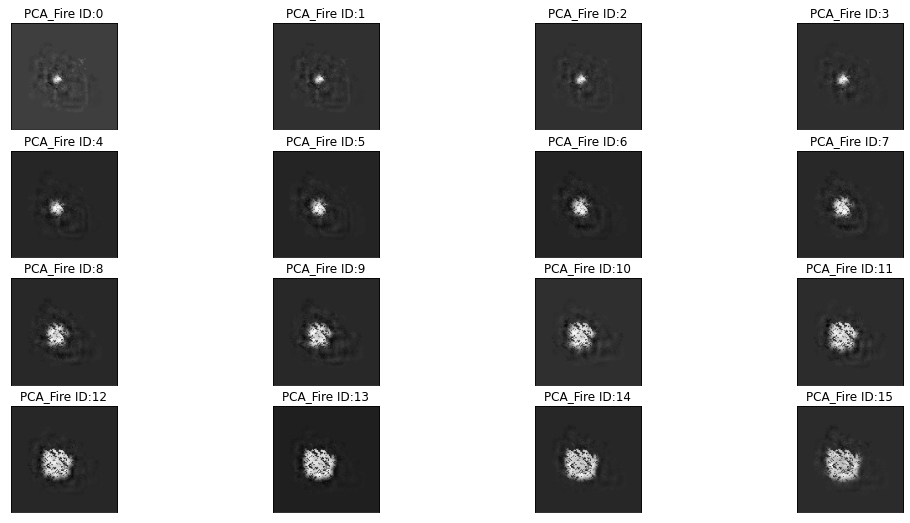

In [13]:
pca = PCA(n_components = 64, whiten = False)
pca_X = pca.fit_transform(X_data)
X_proj_img = pca.inverse_transform(pca_X).reshape(-1,128,128)
fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(X_proj_img[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [14]:
x = np.zeros((16384,))
for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
pca_err_64 =x.sum()/768/128/128

## Show 16 snapshots of first video under 96-PCA


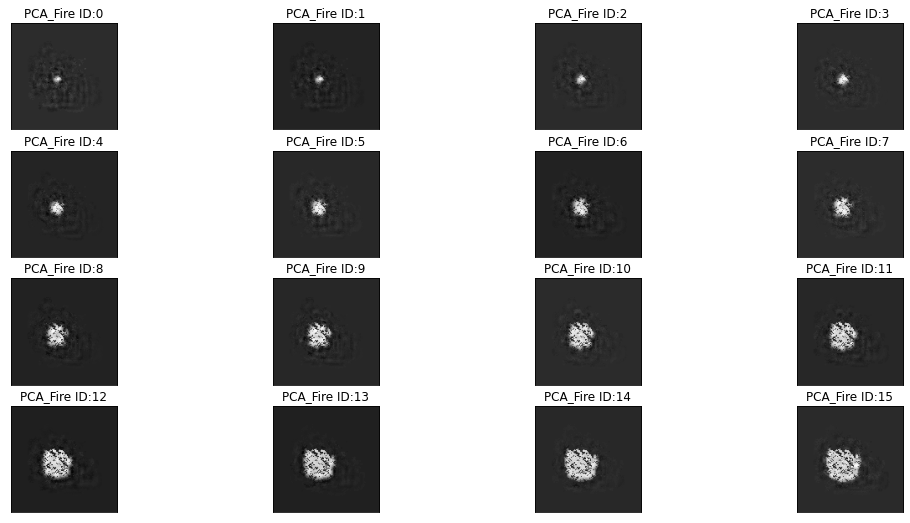

In [15]:
pca = PCA(n_components = 96, whiten = True)
pca_X = pca.fit_transform(X_data)
reduce = np.save('pca_160.npy', pca_X)
X_proj_img = pca.inverse_transform(pca_X).reshape(-1,128,128)

fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(X_proj_img[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [16]:
x = np.zeros((16384,))
for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
pca_err_96 = x.sum()/768/128/128




## Show 16 snapshots of first video under 128-PCA


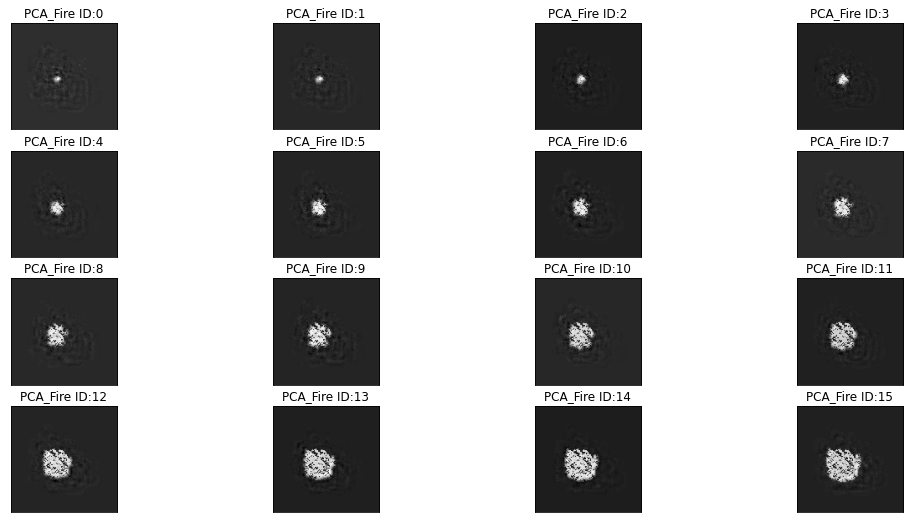

In [17]:
pca = PCA(n_components = 128, whiten = True)
pca_X = pca.fit_transform(X_data)
reduce = np.save('pca_160.npy', pca_X)
X_proj_img = pca.inverse_transform(pca_X).reshape(-1,128,128)

fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(X_proj_img[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [18]:
x = np.zeros((16384,))
for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
pca_err_128 = x.sum()/768/128/128


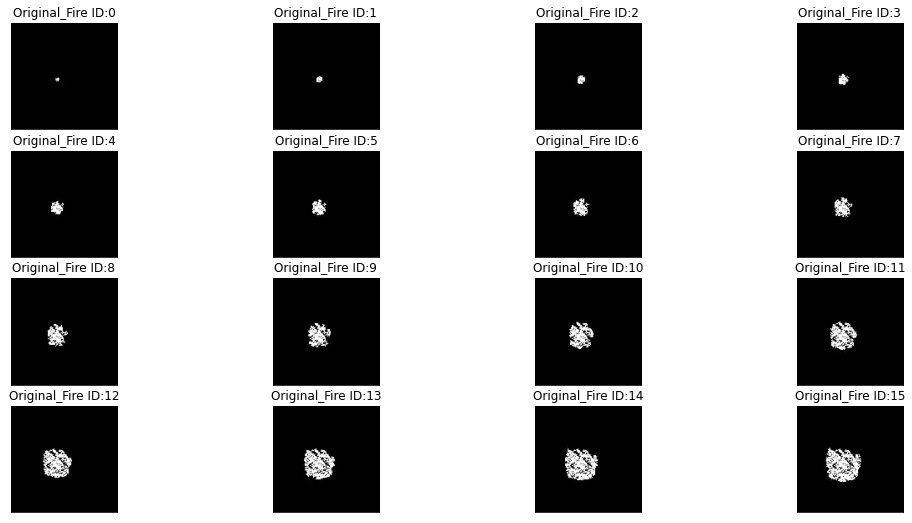

In [19]:
fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(dataset_3D[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("Original_Fire ID:{}".format(ids))

## Show 16 snapshots of first video under original condition

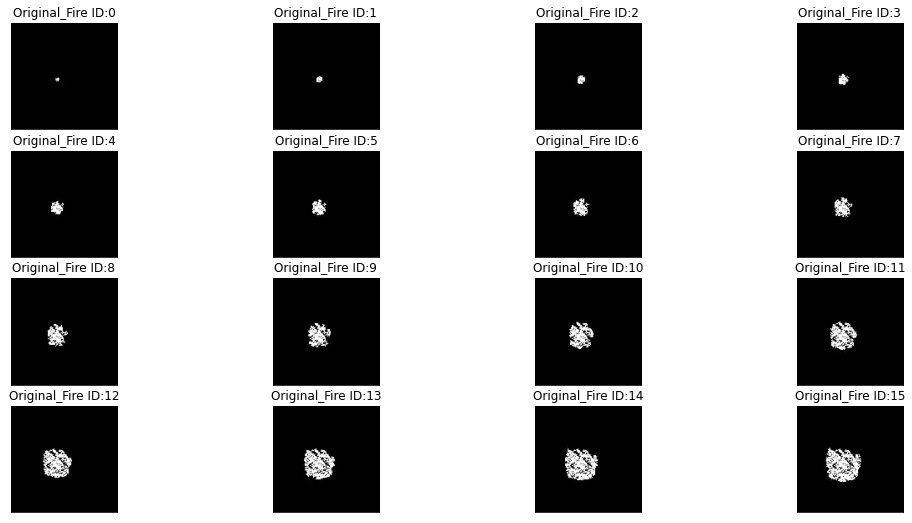

In [20]:
fig, arr = plt.subplots(nrows = 4, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(16):
    ind = ids
    arr[ids].imshow(dataset_3D[ind], cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("Original_Fire ID:{}".format(ids))

# 2. New_version CAE


In [246]:
dataset = np.load('/content/train_dataset3D.npy')
dataset_test = np.load('/content/test_dataset3D.npy')
X = reshape(dataset_3D, (len(dataset_3D), 128, 128, 1)) .astype('float32')/255
x_train = reshape(dataset, (len(dataset), 128, 128, 1)) .astype('float32')/255

x_test = reshape(dataset_test, (len(dataset_test), 128, 128, 1)).astype('float32')/255

In [247]:
def encoder_f(input_img,n):
  #input_img = Input(shape=(128,128, 1))

  x = Conv2D(64, (10, 10), activation='relu', padding='same')(input_img)
  #x = BatchNormalization()(x)
  #x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(n)(x)

  return Model(input_img, x), x

def decoder_f(decode_img):
  x = Dense(256)(decode_img)
  x = Reshape((8, 8, 4), name='predictions')(x)
  x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x) 
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) 
  x = UpSampling2D((2,2))(x) 
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
  x = UpSampling2D((2,2))(x) 
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x) 
  # x = Cropping2D(cropping=((16, 0), (16, 0)), data_format=None)(x)

  decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)
  
  return Model(decode_img, decoded), decoded


## autuencoder-1: *32*

In [248]:
auto_input = Input(shape=(128,128,1))
encoded, x = encoder_f(auto_input,32)

decoded, decode_output = decoder_f(x)
autoencoder_1 = Model(auto_input, decode_output)
autoencoder_1.compile(optimizer='rmsprop', loss='mse')
autoencoder_1.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 64)      6464      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_40 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        924

In [249]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = autoencoder_1.fit(x_train, x_train, epochs=1000, batch_size=2,shuffle=True, validation_data=(x_test, x_test),callbacks=[early_stopping, reduce_lr],)

Epoch 1/1000
320/320 [==============================] - 7s 15ms/step - loss: 0.0146 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/1000
320/320 [==============================] - 6s 19ms/step - loss: 0.0085 - val_loss: 0.0077 - lr: 0.0010
Epoch 3/1000
320/320 [==============================] - 5s 17ms/step - loss: 0.0073 - val_loss: 0.0083 - lr: 0.0010
Epoch 4/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0066 - val_loss: 0.0048 - lr: 0.0010
Epoch 5/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0060 - val_loss: 0.0045 - lr: 0.0010
Epoch 6/1000
320/320 [==============================] - 4s 14ms/step - loss: 0.0056 - val_loss: 0.0047 - lr: 0.0010
Epoch 7/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0051 - val_loss: 0.0043 - lr: 0.0010
Epoch 8/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0049 - val_loss: 0.0039 - lr: 0.0010
Epoch 9/1000
320/320 [==============================] - 4s 13ms/step - l

In [250]:
x = np.zeros((16384,))
X_proj_img = autoencoder_1.predict(dataset_3D)
X_proj_img = np.squeeze(X_proj_img, axis=-1)

for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
err_32 = x.sum()/768/128/128
err_32

24/24 [==============================] - 1s 23ms/step


4.894783733018802

20/20 [==============================] - 1s 22ms/step
First Test Video


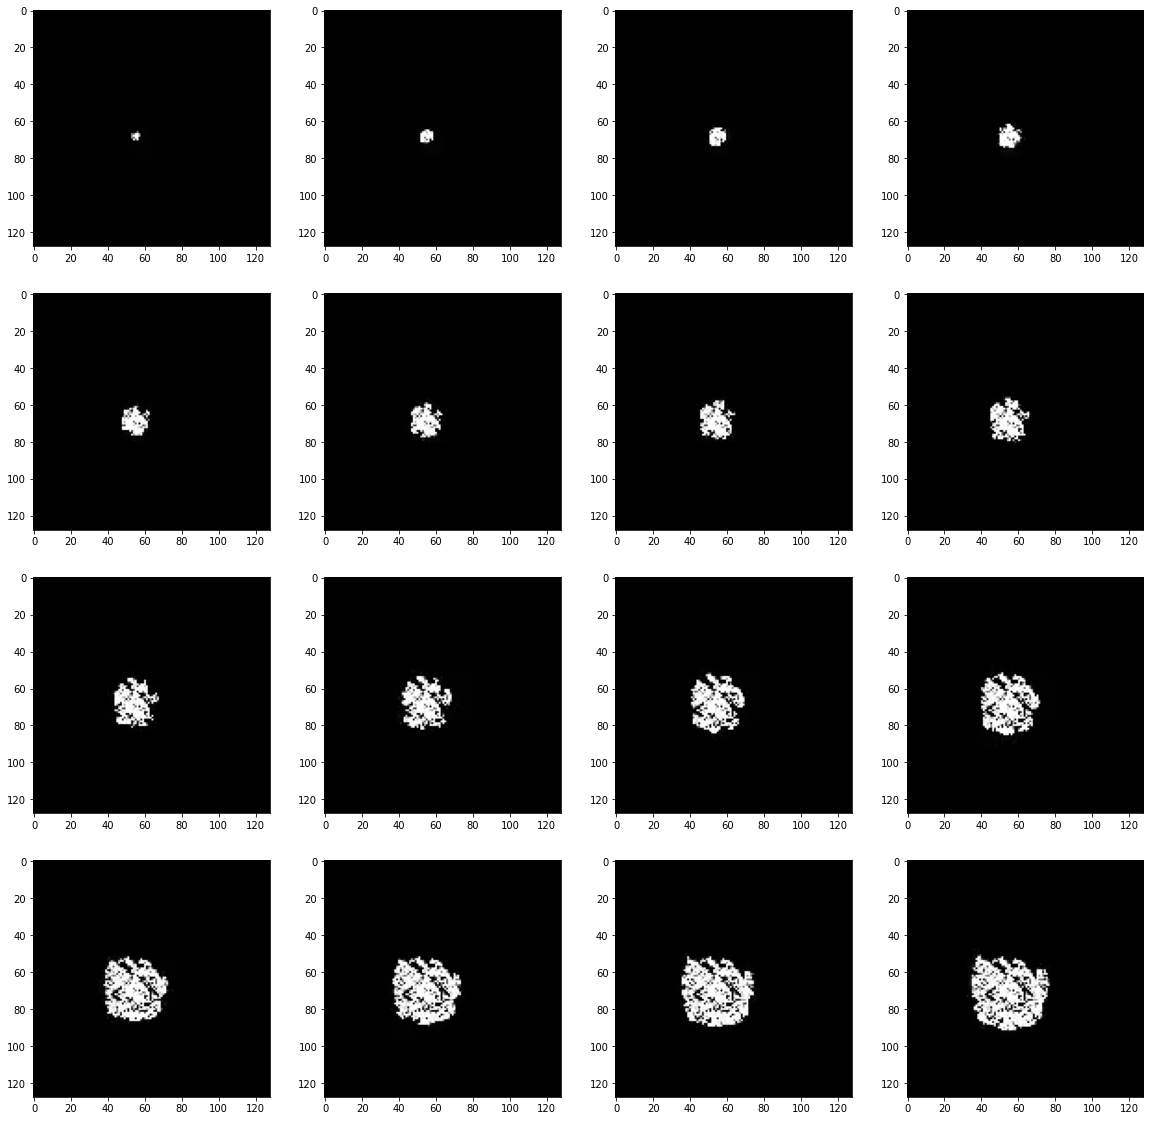

Reconstruction of First Test Images


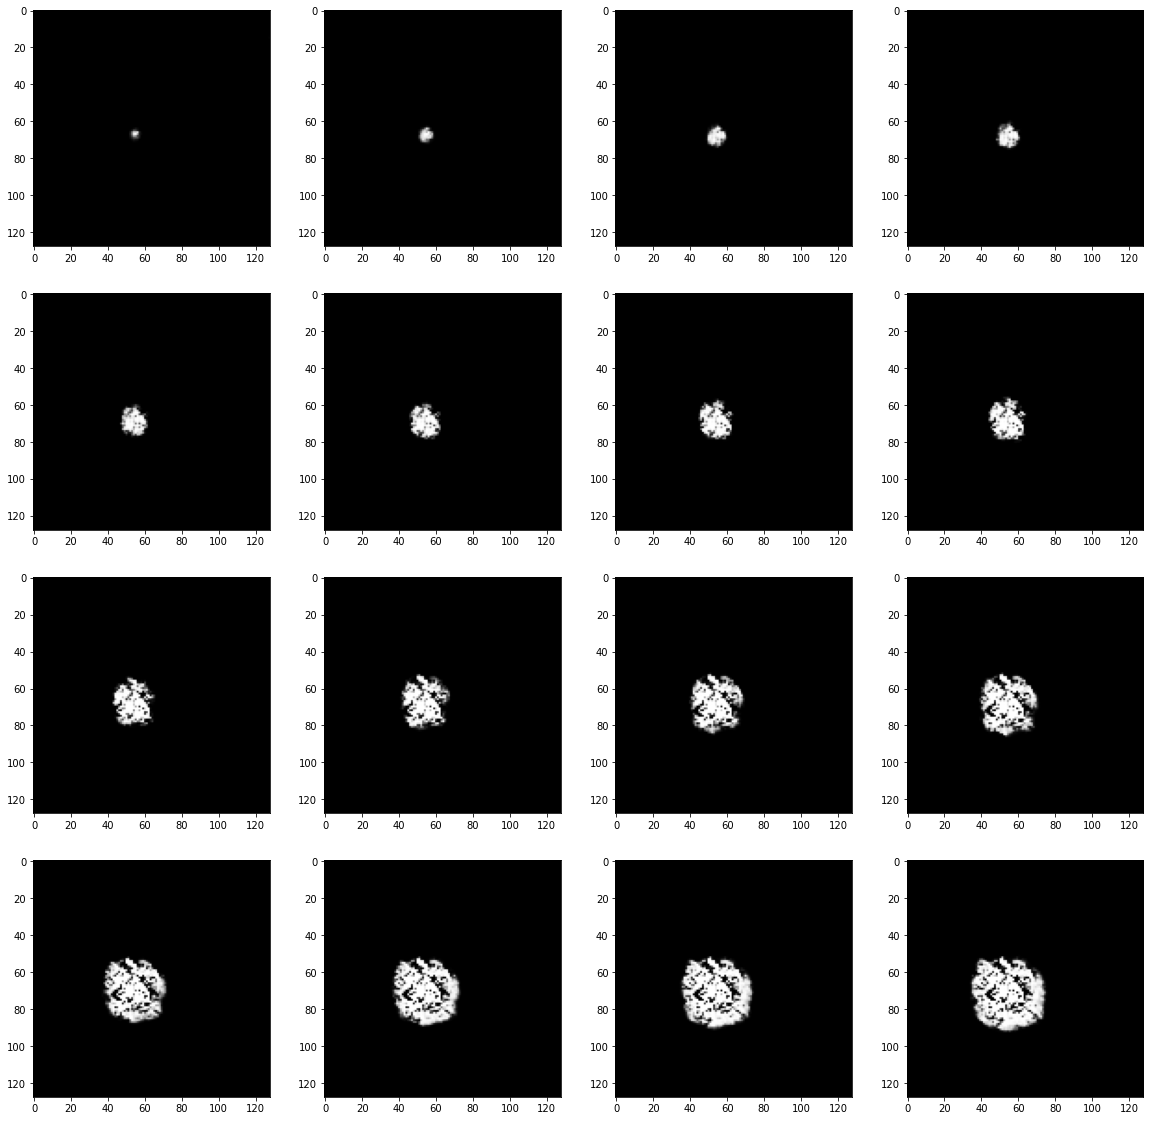

In [251]:
pred = autoencoder_1.predict(x_train)
plt.figure(figsize=(20, 20))
print("First Test Video")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 20))
print("Reconstruction of First Test Images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

## autuencoder-1: *50*

In [270]:
auto_input = Input(shape=(128,128,1))
encoded, x = encoder_f(auto_input,50)

decoded, decode_output = decoder_f(x)
autoencoder_2 = Model(auto_input, decode_output)
autoencoder_2.compile(optimizer='rmsprop', loss='mse')
autoencoder_2.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 128, 128, 64)      6464      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_80 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_122 (Conv2D)         (None, 64, 64, 32)        924

In [271]:
start_time = time.time()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = autoencoder_2.fit(x_train, x_train, epochs=1000, batch_size=2,shuffle=True, validation_data=(x_test, x_test),callbacks=[early_stopping, reduce_lr],)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/1000
320/320 [==============================] - 7s 15ms/step - loss: 0.0137 - val_loss: 0.0081 - lr: 0.0010
Epoch 2/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0085 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0073 - val_loss: 0.0052 - lr: 0.0010
Epoch 4/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0066 - val_loss: 0.0071 - lr: 0.0010
Epoch 5/1000
320/320 [==============================] - 4s 14ms/step - loss: 0.0062 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/1000
320/320 [==============================] - 4s 14ms/step - loss: 0.0058 - val_loss: 0.0045 - lr: 0.0010
Epoch 7/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0055 - val_loss: 0.0044 - lr: 0.0010
Epoch 8/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0053 - val_loss: 0.0040 - lr: 0.0010
Epoch 9/1000
320/320 [==============================] - 4s 13ms/step - l

In [275]:
x = np.zeros((16384,))
X_proj_img = autoencoder_2.predict(dataset_3D)
X_proj_img = np.squeeze(X_proj_img, axis=-1)

for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
err_50 = x.sum()/768/128/128
err_50

24/24 [==============================] - 1s 23ms/step


4.729812434983852

20/20 [==============================] - 0s 10ms/step
First Test Video


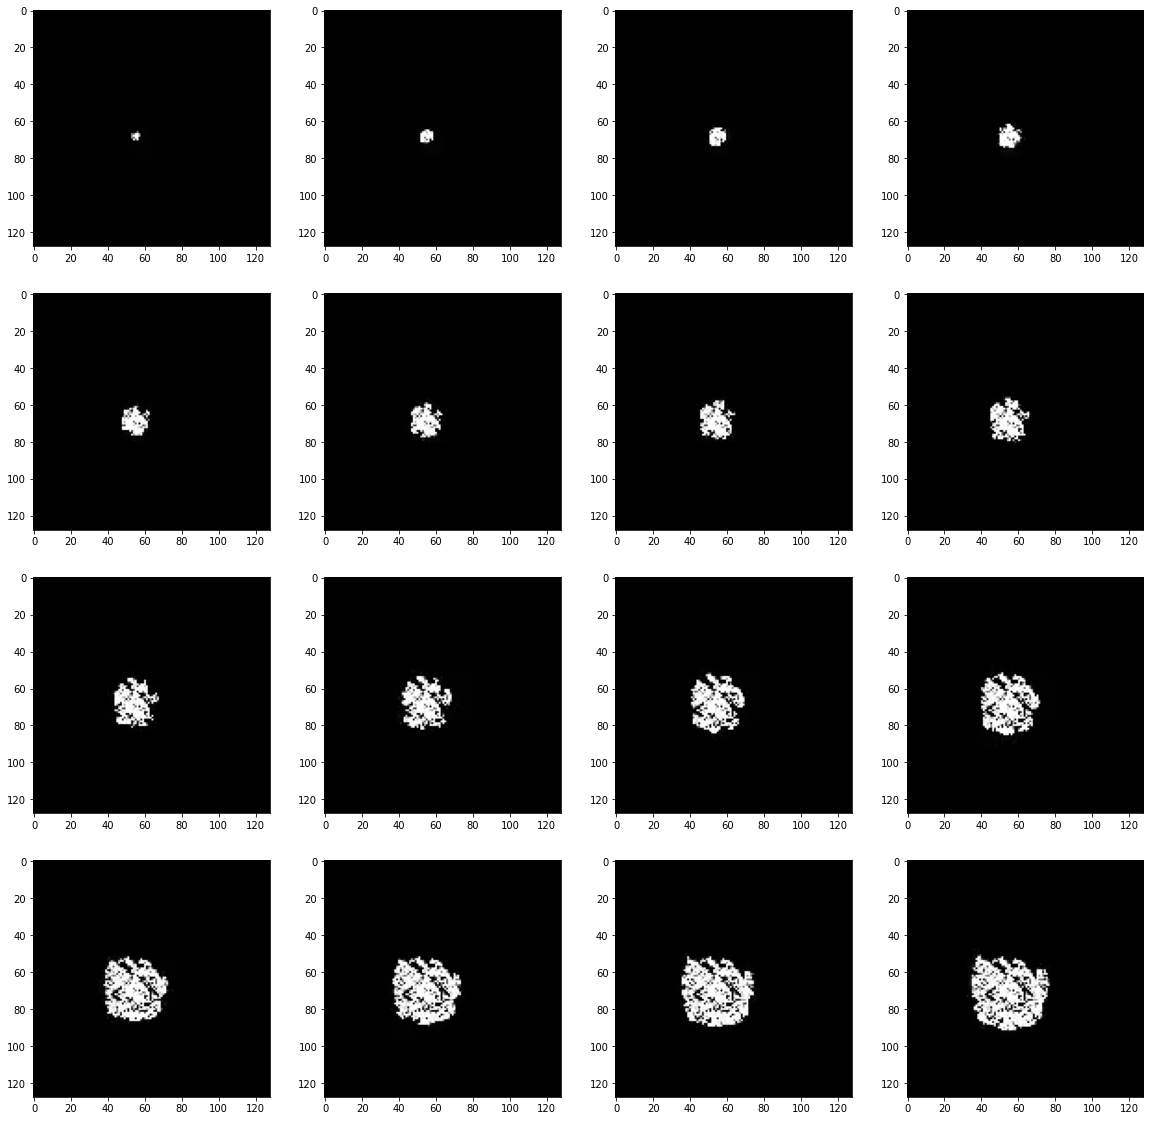

Reconstruction of First Test Images


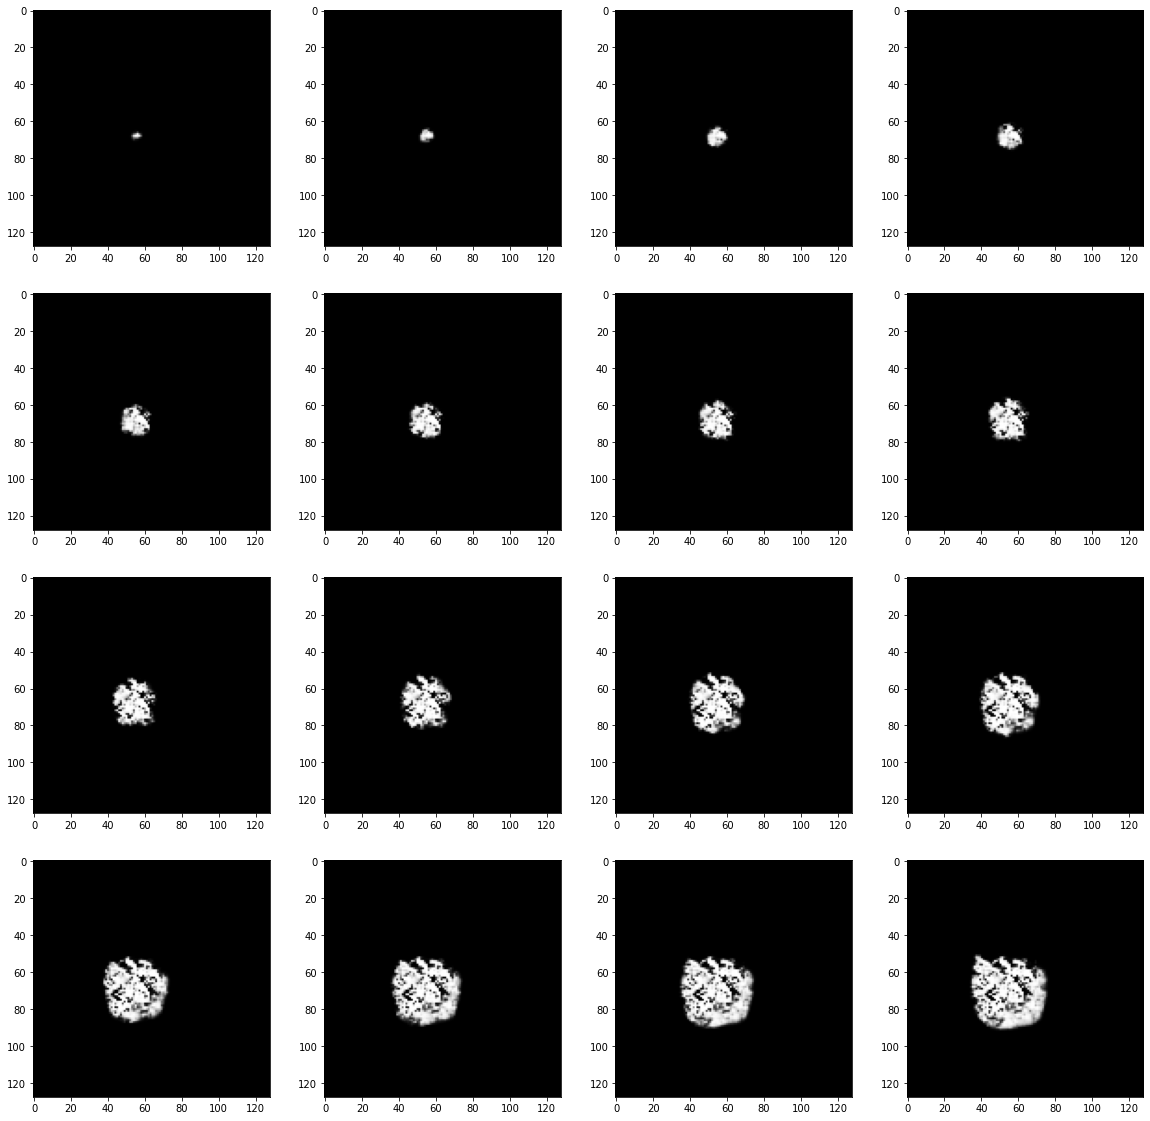

In [276]:
ext = encoded.predict(x_train)
pred = decoded.predict(ext)
#pred = autoencoder_3.predict(x_train)
plt.figure(figsize=(20, 20))
print("First Test Video")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 20))
print("Reconstruction of First Test Images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [274]:
pred.shape

(640, 128, 128, 1)

## autuencoder-1: *64*

In [257]:
auto_input = Input(shape=(128,128,1))
encoded, x = encoder_f(auto_input,64)

decoded, decode_output = decoder_f(x)
autoencoder_3 = Model(auto_input, decode_output)
autoencoder_3.compile(optimizer='rmsprop', loss='mse')
autoencoder_3.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_69 (Conv2D)          (None, 128, 128, 64)      6464      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_56 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 32)        924

In [258]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = autoencoder_3.fit(x_train, x_train, epochs=1000, batch_size=2,shuffle=True, validation_data=(x_test, x_test),callbacks=[early_stopping, reduce_lr],)

Epoch 1/1000
320/320 [==============================] - 7s 14ms/step - loss: 0.0135 - val_loss: 0.0061 - lr: 0.0010
Epoch 2/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0083 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0071 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0065 - val_loss: 0.0049 - lr: 0.0010
Epoch 5/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0059 - val_loss: 0.0046 - lr: 0.0010
Epoch 6/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0054 - val_loss: 0.0053 - lr: 0.0010
Epoch 7/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0052 - val_loss: 0.0043 - lr: 0.0010
Epoch 8/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0049 - val_loss: 0.0040 - lr: 0.0010
Epoch 9/1000
320/320 [==============================] - 4s 13ms/step - l

In [259]:
x = np.zeros((16384,))
X_proj_img = autoencoder_3.predict(dataset_3D)
X_proj_img = np.squeeze(X_proj_img, axis=-1)

for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
err_64 = x.sum()/768/128/128

24/24 [==============================] - 1s 23ms/step


20/20 [==============================] - 1s 21ms/step
First Test Video


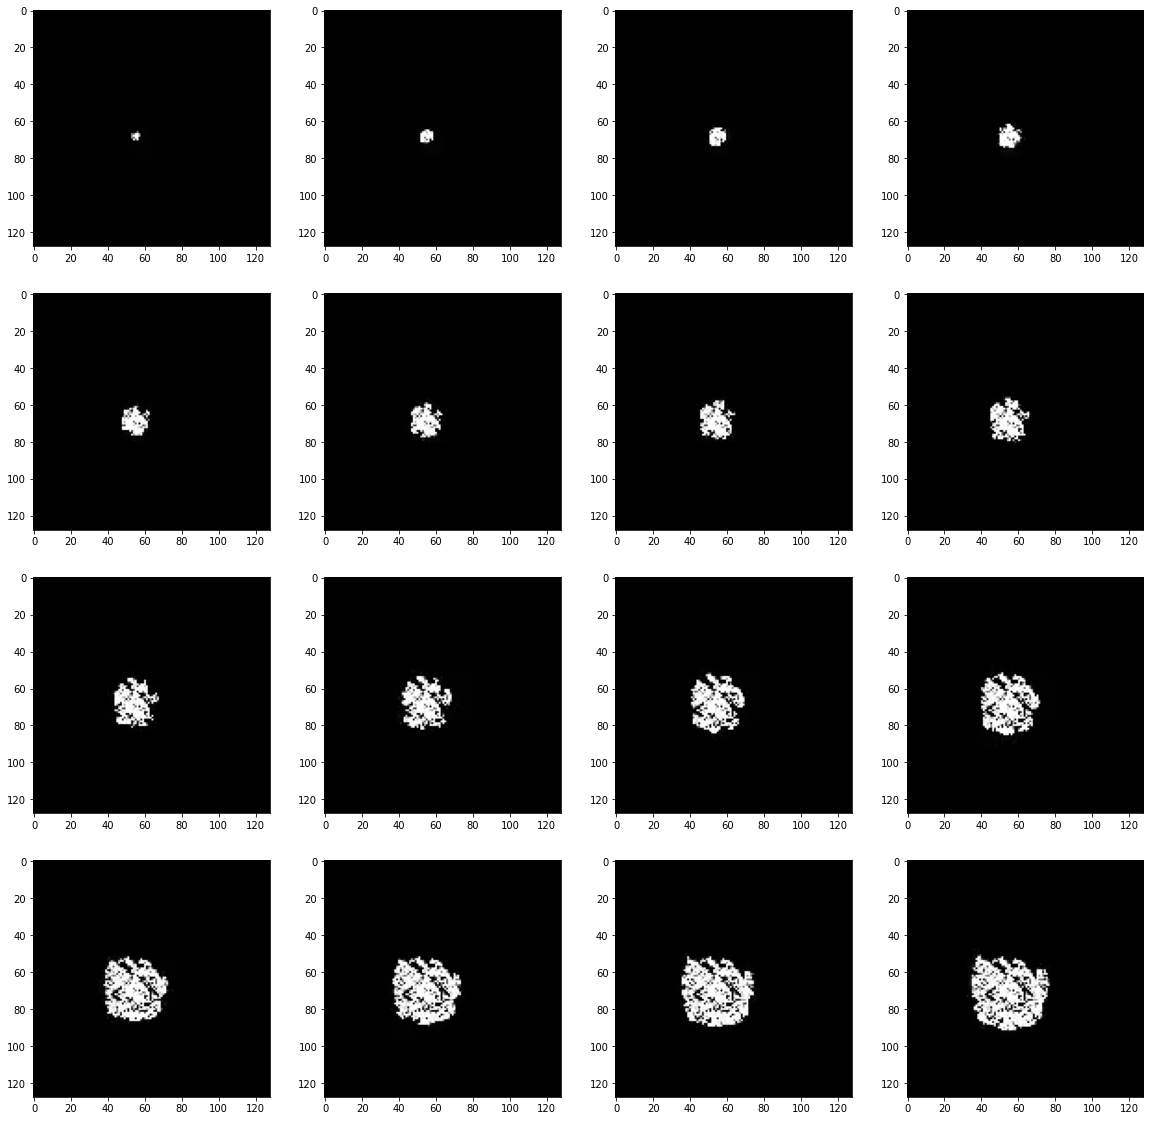

Reconstruction of First Test Images


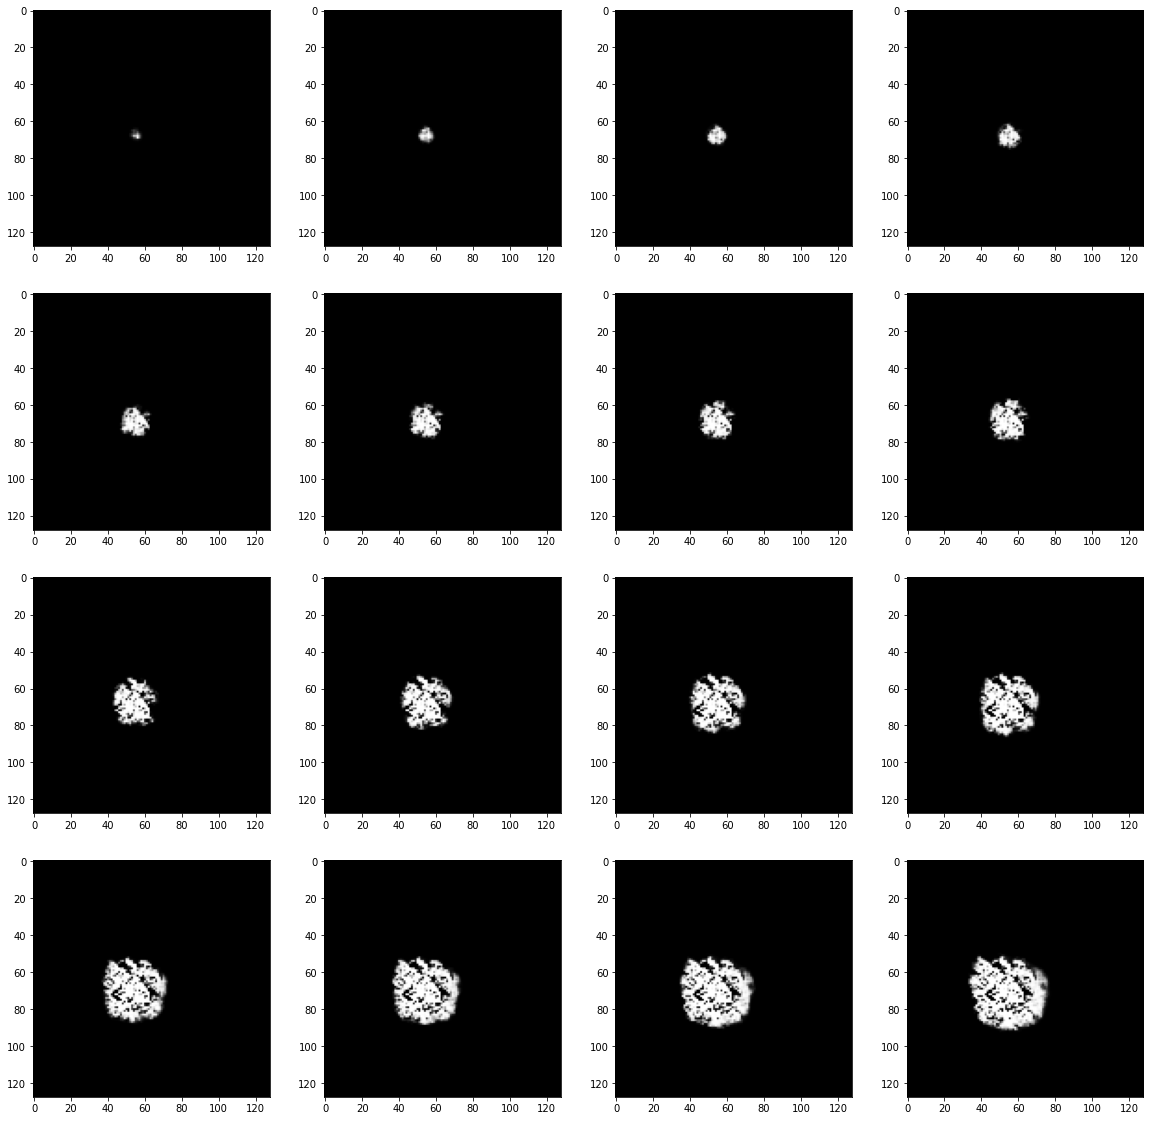

In [260]:
pred = autoencoder_3.predict(x_train)
plt.figure(figsize=(20, 20))
print("First Test Video")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 20))
print("Reconstruction of First Test Images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

## autoencoder - 3: 96

In [261]:
auto_input = Input(shape=(128,128,1))
encoded, x = encoder_f(auto_input,96)

decoded, decode_output = decoder_f(x)
autoencoder_4 = Model(auto_input, decode_output)
autoencoder_4.compile(optimizer='rmsprop', loss='mse')
autoencoder_4.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_86 (Conv2D)          (None, 128, 128, 64)      6464      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_64 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_88 (Conv2D)          (None, 64, 64, 32)        924

In [262]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = autoencoder_4.fit(x_train, x_train, epochs=1000, batch_size=2,shuffle=True, validation_data=(x_test, x_test),callbacks=[early_stopping, reduce_lr],)

Epoch 1/1000
320/320 [==============================] - 7s 14ms/step - loss: 0.0150 - val_loss: 0.0077 - lr: 0.0010
Epoch 2/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0088 - val_loss: 0.0058 - lr: 0.0010
Epoch 3/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0073 - val_loss: 0.0062 - lr: 0.0010
Epoch 4/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0065 - val_loss: 0.0051 - lr: 0.0010
Epoch 5/1000
320/320 [==============================] - 6s 18ms/step - loss: 0.0061 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/1000
320/320 [==============================] - 5s 16ms/step - loss: 0.0057 - val_loss: 0.0047 - lr: 0.0010
Epoch 7/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0054 - val_loss: 0.0053 - lr: 0.0010
Epoch 8/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0050 - val_loss: 0.0046 - lr: 0.0010
Epoch 9/1000
320/320 [==============================] - 4s 13ms/step - l

In [263]:
x = np.zeros((16384,))
X_proj_img = autoencoder_4.predict(dataset_3D)
X_proj_img = np.squeeze(X_proj_img, axis=-1)

for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
err_96 = x.sum()/768/128/128


24/24 [==============================] - 1s 23ms/step


## autoencoder - 3: 128

In [264]:
auto_input = Input(shape=(128,128,1))
encoded, x = encoder_f(auto_input,128)

decoded, decode_output = decoder_f(x)
autoencoder_5 = Model(auto_input, decode_output)
autoencoder_5.compile(optimizer='rmsprop', loss='mse')
autoencoder_5.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_103 (Conv2D)         (None, 128, 128, 64)      6464      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_104 (Conv2D)         (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_72 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_105 (Conv2D)         (None, 64, 64, 32)        924

In [265]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = autoencoder_5.fit(x_train, x_train, epochs=1000, batch_size=2,shuffle=True, validation_data=(x_test, x_test),callbacks=[early_stopping, reduce_lr],)

Epoch 1/1000
320/320 [==============================] - 7s 14ms/step - loss: 0.0133 - val_loss: 0.0071 - lr: 0.0010
Epoch 2/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0082 - val_loss: 0.0075 - lr: 0.0010
Epoch 3/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0071 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0064 - val_loss: 0.0054 - lr: 0.0010
Epoch 5/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0059 - val_loss: 0.0039 - lr: 0.0010
Epoch 6/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0055 - val_loss: 0.0041 - lr: 0.0010
Epoch 7/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0051 - val_loss: 0.0042 - lr: 0.0010
Epoch 8/1000
320/320 [==============================] - 4s 13ms/step - loss: 0.0049 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/1000
320/320 [==============================] - 4s 13ms/step - l

In [266]:
x = np.zeros((16384,))
X_proj_img = autoencoder_5.predict(dataset_3D)
X_proj_img = np.squeeze(X_proj_img, axis=-1)

for i in range(768):
  diff = np.abs((X_proj_img[i]-dataset_3D[i])).flatten()
  x+=diff
err_128 = x.sum()/768/128/128

24/24 [==============================] - 1s 23ms/step


20/20 [==============================] - 1s 22ms/step
First Test Video


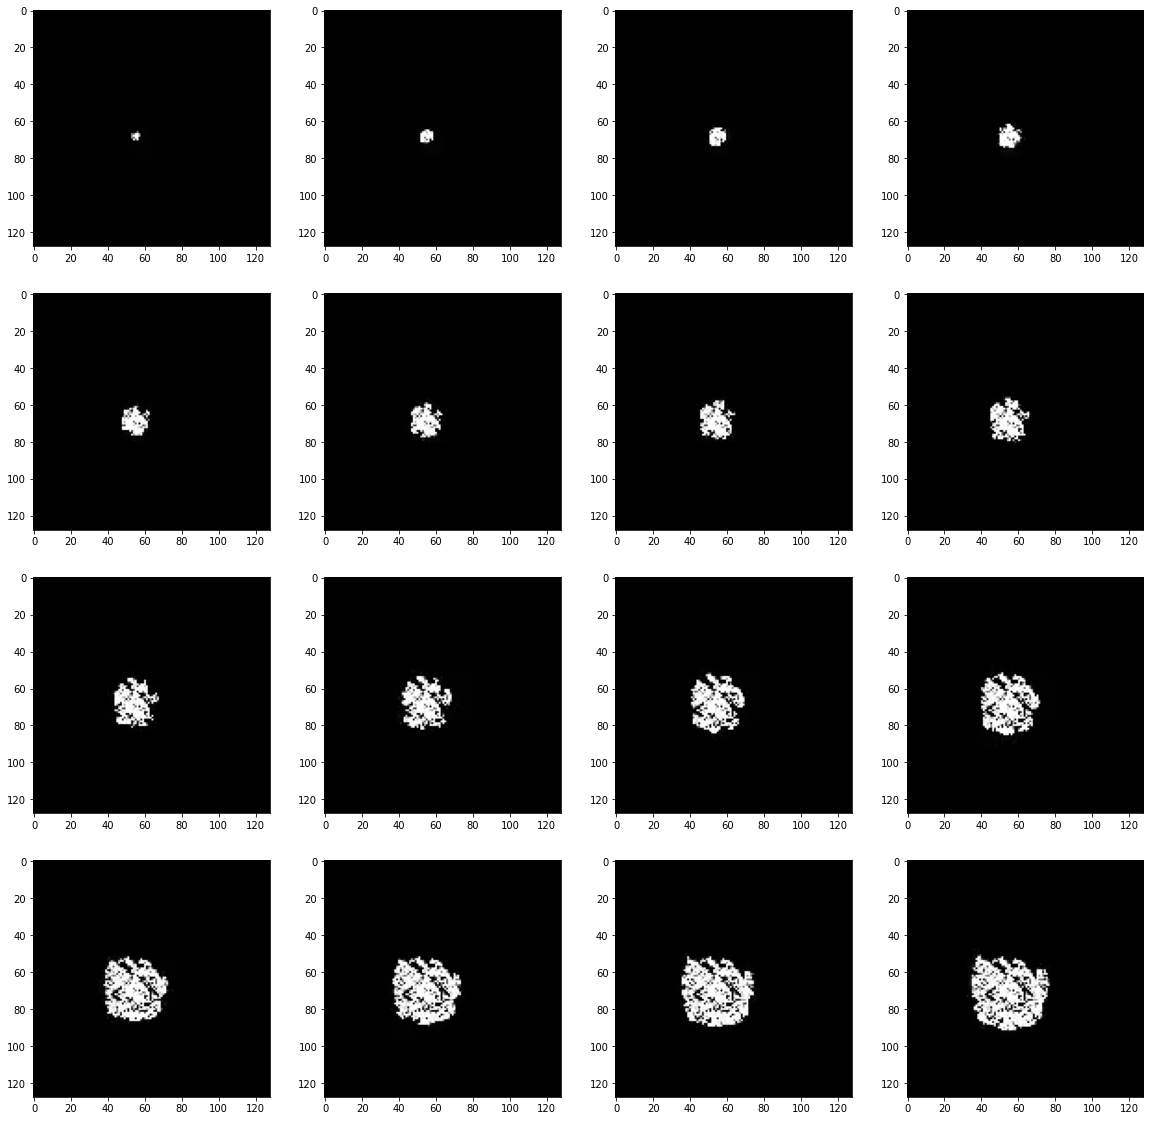

Reconstruction of First Test Images


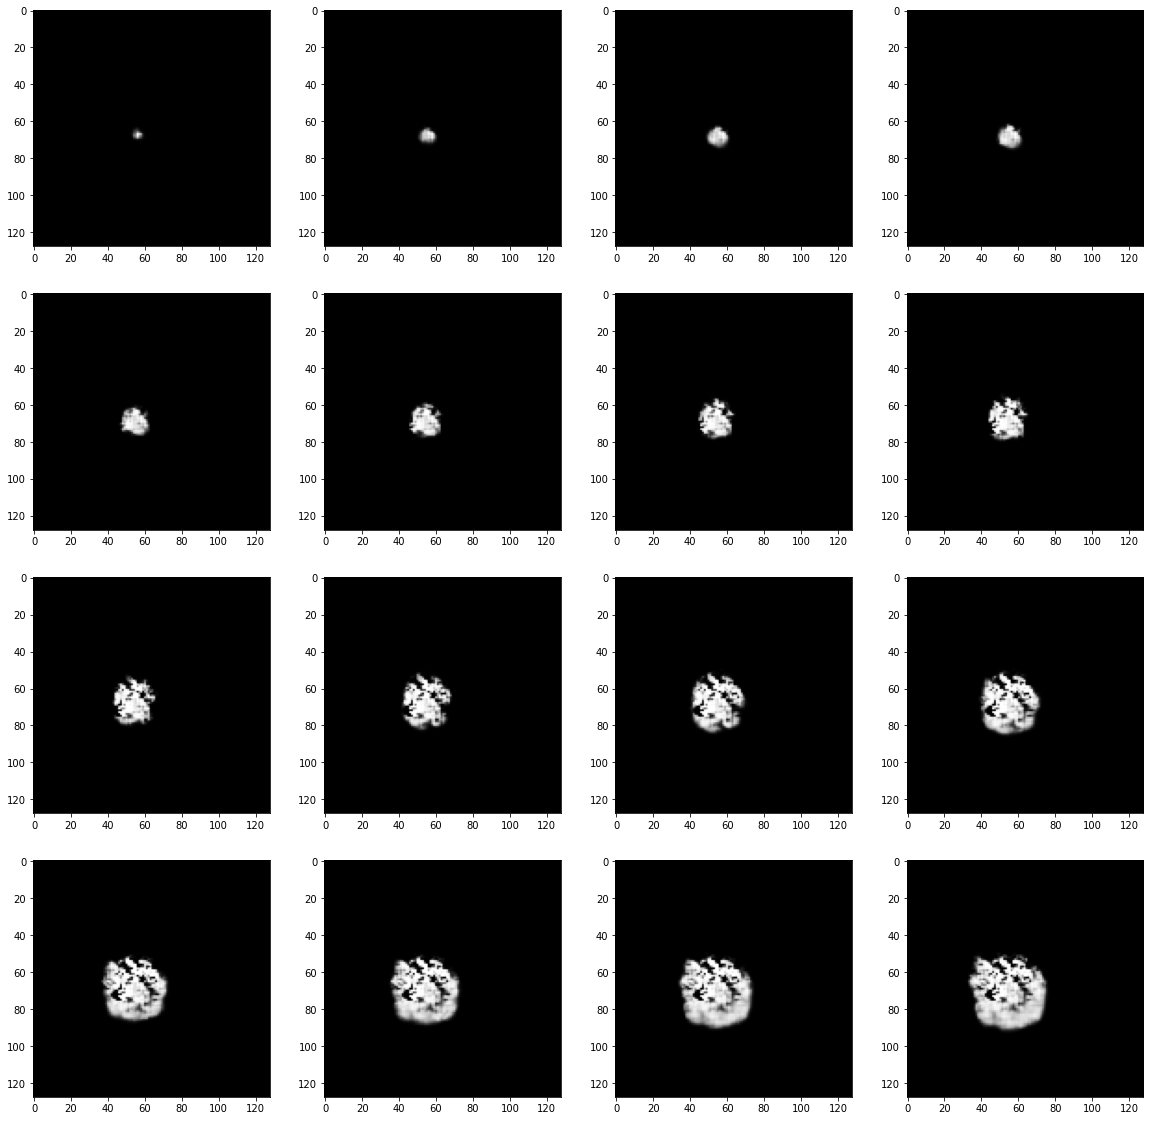

In [267]:
pred = autoencoder_4.predict(x_train)
plt.figure(figsize=(20, 20))
print("First Test Video")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 20))
print("Reconstruction of First Test Images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [277]:
print(err_32)
print(err_50)
print(err_64)
print(err_96)
print(err_128)

4.894783733018802
4.729812434983852
4.885402476595164
4.766555618458457
4.818805018100924


## Figure for Dimensionality Reduction into 32, 50, 64, 96 and 128, respectively on PCA and ConvAutuencoder

The results shows the average error between two sets of data, restruction snapshots and original snapshots, using the L1 norm.

The math formula is
$$
\frac{\left\|\mathbf{y}-\mathbf{y}_{\{\mathrm{PCA}, \mathrm{CAE}\}}\right\|_1}{\operatorname{dim}(\mathbf{y})}
$$

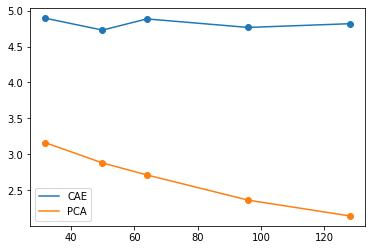

In [278]:
N = [32, 50, 64, 96, 128]
res_1 = [err_32, err_50, err_64, err_96, err_128]
res_2 = [pca_err_32, pca_err_50,pca_err_64,pca_err_96,pca_err_128]
plt.scatter(N, res_1)
plt.scatter(N, res_2)

plt.plot(N, res_1, label = 'CAE')
plt.plot(N, res_2, label = 'PCA')
plt.legend()
plt.show()

# 2. CAE+LSTM

In [151]:
train = np.array(encoded(x_train))
np.save('train.npy',train)

test = np.array(encoded(x_test))
np.save('test.npy',test)
data_lstm = np.array(encoded(X))


In [152]:
#train = np.load('/content/sample_data/train.npy')
#test = np.load('/content/sample_data/test.npy')

scaler = MinMaxScaler(feature_range=(0, 1))

train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(test).astype('float32')
slices_train = np.split(train_sca, len(train)/4)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(test)/4)
val_dataset = np.stack(slices_test, axis=0)

In [153]:
def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :, :]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(159, 4, 50)

In [120]:
model = Sequential()

model.add(LSTM(64,input_shape=(4,50)))
model.add(Dropout(0.3))

model.add(RepeatVector(4))

#multi-step
model.add(LSTM(64, activation='relu', return_sequences=True))
#model.add(BatchNormalization())

model.add(Dropout(0.3))
#model.add(BatchNormalization())


#model.add(Dense(50))

model.add(Dense(50))
#model.add(BatchNormalization())


model.add(TimeDistributed(Dense(50)))

model.add(Activation('relu'))

##################################################################
#training

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 4, 64)            0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 4, 64)             33024     
                                                                 
 dropout_3 (Dropout)         (None, 4, 64)             0         
                                                                 
 dense_6 (Dense)             (None, 4, 50)             3250      
                                                      

In [121]:
start_time = time.time()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100,callbacks=[early_stopping, reduce_lr],batch_size=1, verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
159/159 [==============================] - 4s 12ms/step - loss: 0.0967 - mae: 0.2480 - val_loss: 0.0582 - val_mae: 0.1883 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 2s 9ms/step - loss: 0.0634 - mae: 0.1966 - val_loss: 0.0492 - val_mae: 0.1671 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 1s 9ms/step - loss: 0.0573 - mae: 0.1853 - val_loss: 0.0491 - val_mae: 0.1671 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 2s 10ms/step - loss: 0.0534 - mae: 0.1767 - val_loss: 0.0478 - val_mae: 0.1635 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 1s 9ms/step - loss: 0.0494 - mae: 0.1678 - val_loss: 0.0430 - val_mae: 0.1517 - lr: 0.0010
Epoch 6/100
159/159 [==============================] - 2s 10ms/step - loss: 0.0437 - mae: 0.1583 - val_loss: 0.0376 - val_mae: 0.1442 - lr: 0.0010
Epoch 7/100
159/159 [==============================] - 1s 9ms/step - loss: 0.0308 - mae: 0.1382 - val_loss: 0.0225 - val_

In [154]:
x_train.shape

(159, 4, 50)

In [155]:
# make predictions
trainPredict = model.predict(x_train).reshape((636,50))
testPredict = model.predict(x_val).reshape((124,50))
y_train = y_train.reshape((636,50)) 
y_val = y_val.reshape((124,50))                       

1/1 [==============================] - 0s 18ms/step


In [156]:
trainPredict.shape

(636, 50)

In [157]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_val)

x_train = scaler.inverse_transform(x_train.reshape(636,50))
x_train = decoded(x_train)

In [158]:
trainPredict = decoded(trainPredict)
trainY = decoded(trainY)
testPredict = decoded(testPredict)
testY = decoded(testY)


In [159]:
np.max(trainPredict)

1.0

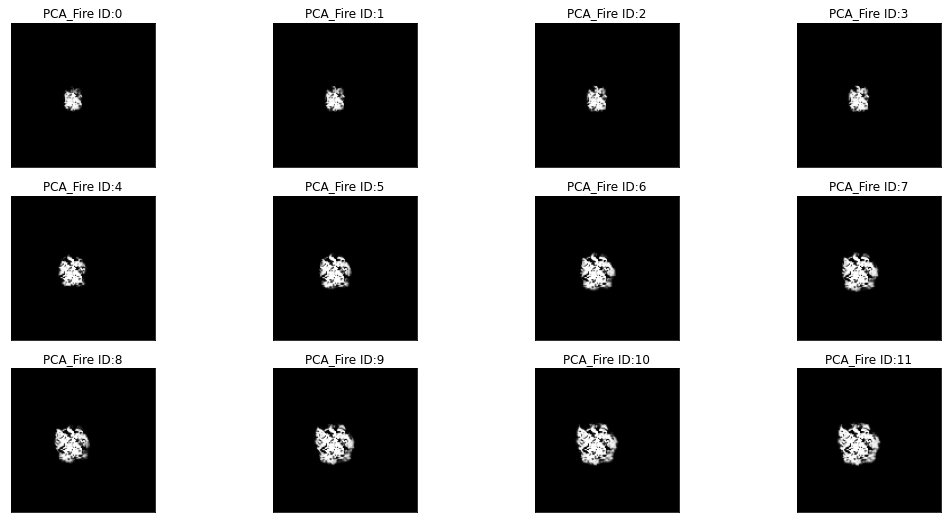

In [160]:
trainPredict_show = trainPredict[:12,:,:,:]
trainPredict_show.shape
fig, arr = plt.subplots(nrows = 3, ncols = 4, figsize = (18, 9))
arr = arr.flatten()
for ids in range(12):
    arr[ids].imshow(np.squeeze(trainPredict_show[ids]), cmap = 'gray')
    arr[ids].set_xticks([])
    arr[ids].set_yticks([])
    arr[ids].set_title("PCA_Fire ID:{}".format(ids))

In [245]:
mse = np.mean((testY - testPredict)**2)
rmse = np.sqrt(mse)
rmse

0.061775286

In [162]:
testY.shape

TensorShape([124, 128, 128, 1])

In [163]:
testY = np.array(testY).reshape((124,128,128))
testPredict = np.array(testPredict).reshape((124,128,128))
error = structural_similarity(testY, testPredict,multichannel=False)

print(f'Error: {error:.2f}')

Error: 0.96


### CAE+LSTM

RMSE : 0.0618

SSIM : 0.96

ALL Based on original images and restruction images


# 3. Conv-LSTM


In [232]:
import cv2
import numpy as np

dataset_3D = []
dataset = []
data_conv = []
for i in range(48):
    video = cv2.VideoCapture("/content/drive/MyDrive/UROP Sibo/A Machine learning problem/VIDEOS/fire_Chimney_video_{}.mp4".format(i))
    
    data_3 = []
    while True:
        ret, frame = video.read()
        
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        binary_flat = binary.flatten()
        
        dataset.append(binary_flat)
        dataset_3D.append(gray)
        data_3.append(gray)
    data_conv.append(data_3)

dataset = np.array(dataset)
dataset_3D = np.array(dataset_3D)
print(dataset.shape)

(768, 16384)


In [233]:
data_conv = np.array(data_conv)
data_conv.shape
dataset = data_conv

In [234]:
dataset = np.expand_dims(dataset, axis=-1)
dataset.shape

(48, 16, 128, 128, 1)

In [235]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: 40]
val_index = indexes[40 :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

In [236]:
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [237]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (40, 15, 128, 128, 1), (40, 15, 128, 128, 1)
Validation Dataset Shapes: (8, 15, 128, 128, 1), (8, 15, 128, 128, 1)


Displaying frames for example 15.


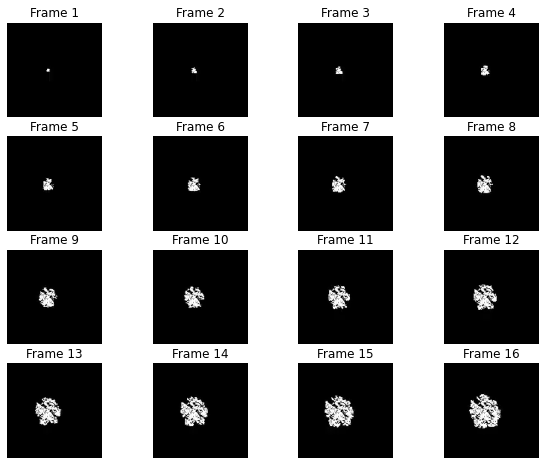

In [238]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

In [239]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3,3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
)(x)

x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.mse, optimizer=keras.optimizers.Adam(),
)
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_33 (ConvLSTM2D)  (None, None, 128, 128, 1  9856     
                             6)                                  
                                                                 
 batch_normalization_38 (Bat  (None, None, 128, 128, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv_lstm2d_34 (ConvLSTM2D)  (None, None, 128, 128, 1  18496    
                             6)                                  
                                                                 
 batch_normalization_39 (Bat  (None, None, 128, 128, 1  64

In [240]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 100
batch_size = 2

start_time = time.time()

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
20/20 [==============================] - 9s 275ms/step - loss: 0.0541 - val_loss: 0.0278 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 5s 244ms/step - loss: 0.0080 - val_loss: 0.0218 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 5s 243ms/step - loss: 0.0066 - val_loss: 0.0210 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 5s 244ms/step - loss: 0.0060 - val_loss: 0.0206 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 5s 246ms/step - loss: 0.0056 - val_loss: 0.0202 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 5s 249ms/step - loss: 0.0052 - val_loss: 0.0199 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 5s 252ms/step - loss: 0.0048 - val_loss: 0.0195 - lr: 0.0010
Epoch 8/100
20/20 [==============================] - 5s 247ms/step - loss: 0.0045 - val_loss: 0.0192 - lr: 0.0010
Epoch 9/100
20/20 [==============================] - 5s 249ms/step - loss: 0.0041 - val_

1/1 [==============================] - 0s 76ms/step


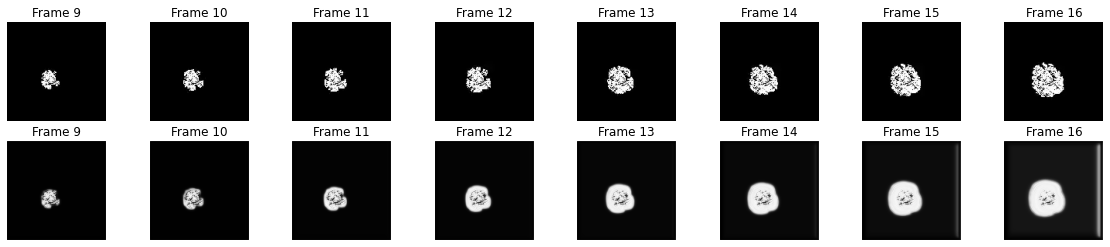

In [244]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:8, ...]
original_frames = example[8:, ...]

for _ in range(8):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 8, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 9}")
    ax.axis("off")

new_frames = frames[8:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 9}")
    ax.axis("off")

plt.show()

In [242]:
y_val = y_val.reshape((120,128,128))
y_pred = model.predict(x_val).reshape((120,128,128))
error = structural_similarity(y_val, y_pred,multichannel=False)

mse = np.mean((y_val - y_pred)**2)
rmse = np.sqrt(mse)

1/1 [==============================] - 0s 171ms/step


<ipython-input-242-ead3bd754bd4>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  error = structural_similarity(y_val, y_pred,multichannel=False)


In [243]:
print(error)
print(mse)
print(rmse)

0.968146969793889
0.0007829778851874285
0.02798174199701349


# Table for evalution results on Test datasets and online computional time on train datasets

| Name of Models/Evalution Metrics | MSE    | RMSE   | SSIM | Train Time (s) |
|----------------------------------|--------|--------|------|----------------|
| CAE + LSTM                       | 0.0038 | 0.0617 | 0.96 | 332
| ConvLSTM                         | 0.0007 | 0.0279 | 0.97 | 447.90        | 

Based on the results (MSE, RMSE, SSIM), it appears that the ConvLSTM model is performing much better than the CAE-LSTM model on the test dataset. This could be due to a number of factors, including the specific characteristics of the dataset, the design of the models, and the hyperparameters used. It's also possible that the ConvLSTM model is simply a better fit for the task. From the aspect of online training computional time, CAE+LSTM shows a better performance than ConvLSTM.

Some potential explanations include:
1. The quality of the features: The ConvLSTM model is able to extract more relevant and useful features from the input data than the CAE-LSTM model, leading to better performance.

2. The complexity of the models: The ConvLSTM model is able to capture more complex patterns in the data than the CAE-LSTM model, leading to better performance. (Not more complex, more better. A overfitting question should be considered in the design of the model.)

| Name of Models/Number | trainable params  |
|-----------------------|-------------------|
| CAE + LSTM            | 68,264            |
| ConvLSTM              | 35,577            | 

3. The hyperparameters of the models: The specific values of the hyperparameters (such as the learning rate, the number of layersm, loss function, optimizer) used for the ConvLSTM and CAE-LSTM models could be affecting their performance. You know, the hyperparameters'choice of DL models are unexplainable and unknown. Any params lead to any results.

4. The characteristics of the dataset: The ConvLSTM model may simply be a better fit for the specific characteristics of the wildfire prediction dataset.

A common problem is that performance of models is limited by the size of the dataset. In the future, probabilistic DL methods can be considered for the prediction of wildfires, such as probabilistic cGAN, GP and MDN.

# 4. Some Strategy

1. Data preprocessing: If the wildfire field can only be increasing, it means that any decrease in the field area is most likely due to errors in the data collection or processing. Therefore, it may be helpful to identify and remove such erroneous data points before training the model.

2. Model design: We can incorporate this information into the design of the model by using an architecture that only allows for increasing predictions. For example, a monotonic activation function such as the sigmoid function or the softplus function can be used to ensure that the model only produces increasing outputs.

3. Loss function: We can also modify the loss function to encourage the model to make only increasing predictions. One way to do this is to add a penalty term to the loss function for decreasing predictions. The loss function can be motified used to train the model to encourage monotonic behavior. One way to do this is to add a penalty term to the loss function for decreasing predictions. For example, the following loss function:
$$
loss = (1-k) * MSE + k * abs(y_p - y_t)
$$
where $k$ is a hyperparameter that controls the weight of the penalty term.


4. Training strategy: We can also use a training strategy that explicitly encourages the model to make only increasing predictions. For example, a curriculum learning approach is avaliable, where the model is first trained on easy examples where the wildfire field is increasing, and then gradually exposed to more challenging examples. The training data is presented to the model in a sequence of increasingly difficult tasks. This can help the model learn to make only increasing predictions more effectively.

5. Data augmentation: Use data augmentation techniques to generate additional training data that is consistent with the monotonicity constraint. For example, we could generate synthetic examples where the wildfire field is increasing by applying transformations to the existing data that preserve the monotonic relationship. Throughout the implementation of autoencoder and LSTM, the overfitting caused by the small dataset was evident, but the network structure was not well generalised if simplified, so a larger dataset was necessary.